In [44]:
import pandas as pd
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Gerando time series de dados de receitas

Corrigindo alguns encodings diferentes:

In [6]:
receitas_df = pd.DataFrame()

Criando um arquivo único com a série temporal:

In [7]:
for year in range(2008, 2020):
    year_df = pd.read_csv(f'../data/receitas/receitas-{year}.csv', sep=";", encoding=("iso-8859-9" if year < 2013 else "windows-1254"))

    year_df["vl_arrecadacao"] = (
        year_df["vl_arrecadacao"]
        .apply(lambda x: float(x.replace(",", ".")))
        .astype(float)
    )

    year_df = year_df[
        ["ds_municipio", "ano_exercicio", "mes_referencia", "vl_arrecadacao"]
    ].groupby(["ds_municipio", "ano_exercicio", "mes_referencia"]).sum().reset_index()
    receitas_df = pd.concat([receitas_df, year_df])

In [8]:
receitas_df.head()

,ds_municipio,ano_exercicio,mes_referencia,vl_arrecadacao
0,Adamantina,2008,1,5939135.41
1,Adamantina,2008,2,6111833.24
2,Adamantina,2008,3,5509312.00
3,Adamantina,2008,4,5262156.16
4,Adamantina,2008,5,5221109.90


In [46]:
receitas_df.to_csv("../data/generated/receitas-timeseries.csv")

In [64]:
receitas_df.head()

,ds_municipio,ano_exercicio,mes_referencia,vl_arrecadacao
0,Adamantina,2008,1,5939135.41
1,Adamantina,2008,2,6111833.24
2,Adamantina,2008,3,5509312.00
3,Adamantina,2008,4,5262156.16
4,Adamantina,2008,5,5221109.90


In [91]:
receitas_mean = receitas_df.groupby(['ano_exercicio', 'mes_referencia']).mean().reset_index()

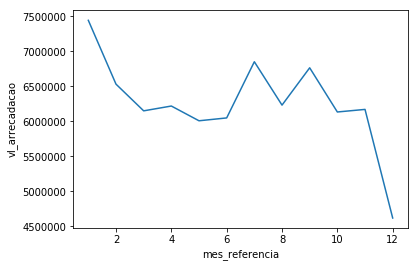

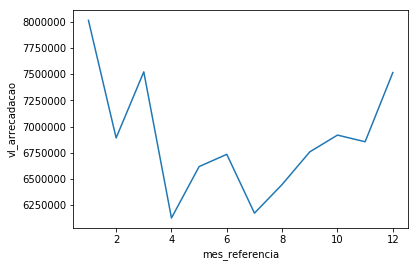

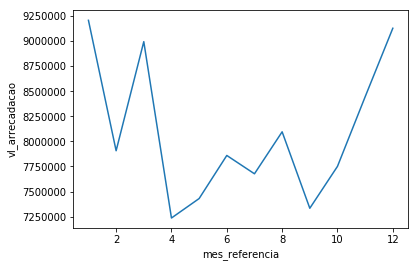

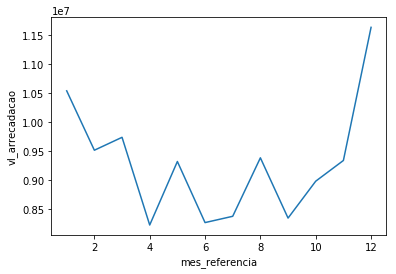

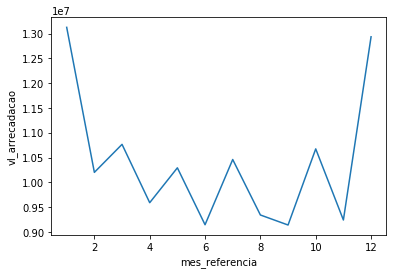

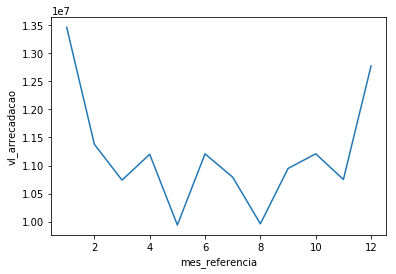

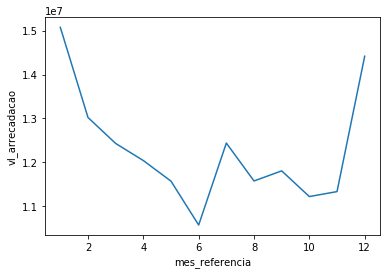

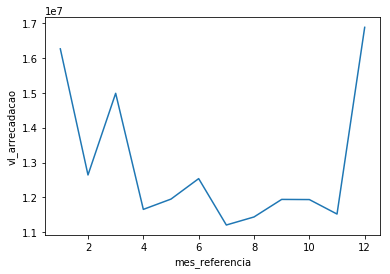

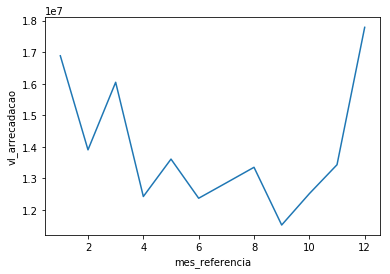

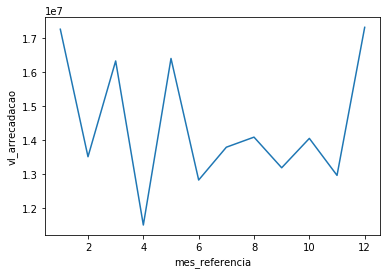

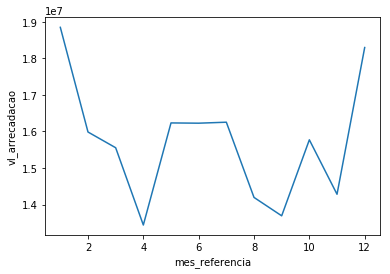

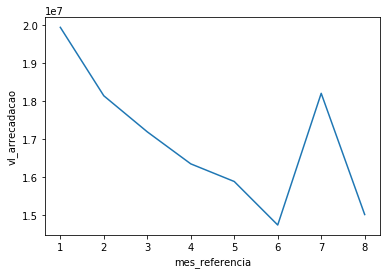

In [92]:
for year in range(2008, 2020):
    year_df = receitas_mean[receitas_mean.ano_exercicio == year]
    sns.lineplot(x='mes_referencia', y='vl_arrecadacao', data=year_df)
    plt.show()

Com exceção de alguns anos, vemos que a arrecadação segue um padrão geral em formato de "U", ou seja, é alta no começo e no fim do ano (o que, na prática, representa o mesmo período, dada a continuidade dos anos), que é quando os maiores impostos são colhidos. Podemos observar picos que podem representar certas sazonalidades como feriados ou períodos produtivos específicos de cada cidade.

Parece adequado fazer previsões baseadas em _time series_ com esses dados, e a ferramenta utilizada (*Facebook Prophet*) se encarregará de equilibrar outliers e sazonalidades. Faremos previsões de receitas para o ano incompleto, baseados no histórico de série temporal.

# Despesas

In [62]:
despesas_df = pd.DataFrame()

Como os arquivos de dados para despesas são extremamente massivos, a leitura dos mesmos se dará de forma mais discretizada. Seria possivel paralelizar esse processamento, mas por questões de simplicidade e agilidade, não será feito.

In [63]:
for year in range(2008, 2020):
    print(year)
    for year_df in pd.read_csv(f'../data/despesas/despesas-{year}.csv', sep=";",
                               encoding=("iso-8859-9" if year < 2013 else "windows-1254"),
                               usecols=["ds_municipio", "ano_exercicio", "mes_referencia", "vl_despesa"],
                               dtype={"ds_municipio": str,
                                      "ano_exercicio": int,
                                      "mes_referencia": int,
                                      "vl_despesa": str},
                               chunksize=1000000):
        year_df["vl_despesa"] = (
            year_df["vl_despesa"]
            .apply(lambda x: float(x.replace(",", ".")))
            .astype(float)
        )

        year_df = year_df.groupby(["ds_municipio", "ano_exercicio", "mes_referencia"]).sum().reset_index()
        despesas_df = pd.concat([despesas_df, year_df])

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [67]:
grouped_despesas = despesas_df.groupby(["ds_municipio", "ano_exercicio", "mes_referencia"]).sum().reset_index()

In [73]:
grouped_despesas.to_csv("../data/generated/despesas-timeseries.csv")

In [77]:
grouped_despesas.head()

,ds_municipio,ano_exercicio,mes_referencia,vl_despesa
0,Adamantina,2008,1,15112405.72
1,Adamantina,2008,2,13135894.65
2,Adamantina,2008,3,15175780.95
3,Adamantina,2008,4,16810449.53
4,Adamantina,2008,5,18624850.27


In [95]:
despesas_mean = grouped_despesas.groupby(['ano_exercicio', 'mes_referencia']).mean().reset_index()

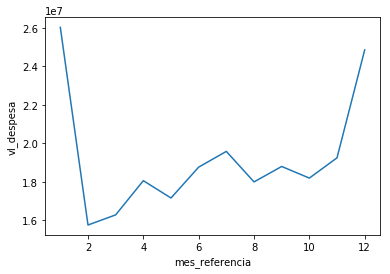

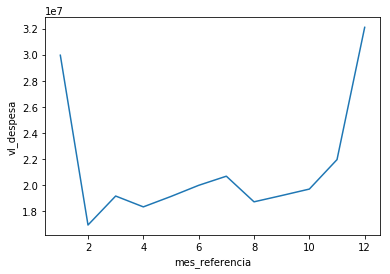

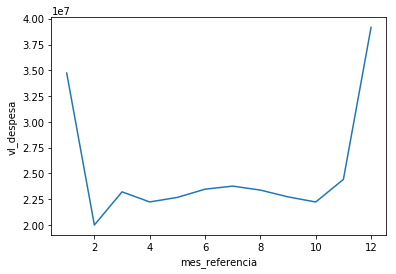

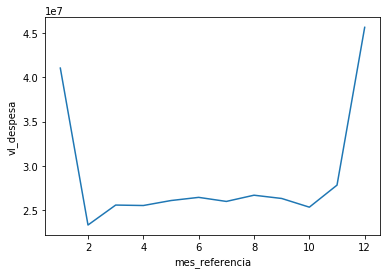

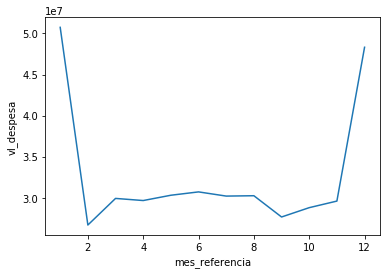

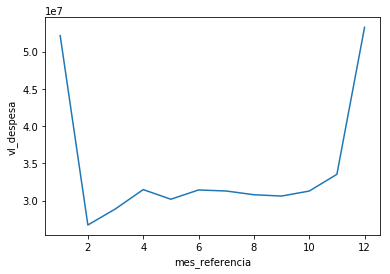

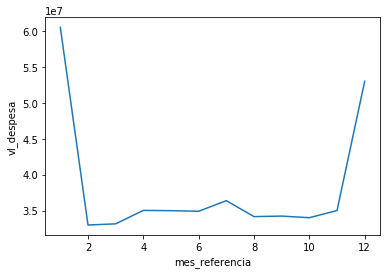

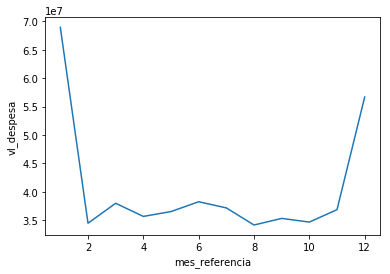

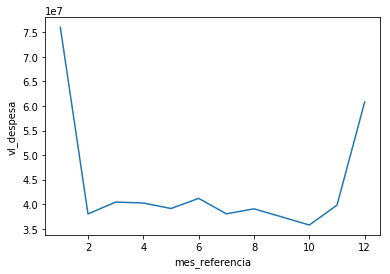

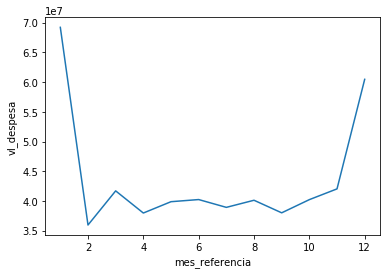

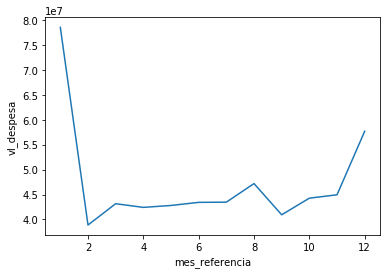

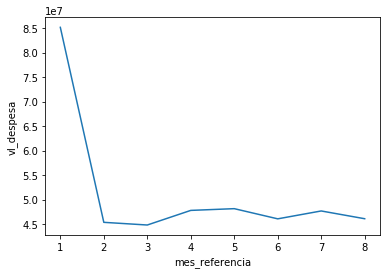

In [97]:
for year in range(2008, 2020):
    year_df = despesas_mean[despesas_mean.ano_exercicio == year]
    sns.lineplot(x='mes_referencia', y='vl_despesa', data=year_df)
    plt.show()

As despesas parecem seguir o mesmo padrão das receitas, o que faz sentido, pois as contas têm que fechar no final de cada ano. No entanto, justamente por isso, as "curvas" de despesas parecem ser mais "suaves".